# What is my goal with this project?
As a citizen of Porto Alegre for more than 25 years I started to have the feeling that our weather is changing a little on these last years. Out of curiosity I wanted to visualize what differences are perceptible.

This is a simple project intended only to consolidate my knowledge of pandas, matplotlib and seaborn as I'm currently deepening my comprehension of them.

### Dataset index & columns
0. date: from 2001-01-01 to 2022-03-10. As index.
1. total_precip: daily total precipitation.
2. max_temp: daily maximum temperature.
3. avg_temp: daily average temperature.
4. min_temp: daily minimum temperature.
5. avg_humidity: daily average humidity.
6. min_humidity: daily minimum humidity.

### What steps will be done:
* Data extraction: load .csv
* Data preparation: clean useless cols & rows, simplify & translate cols, convert data types, decrease the amount of NaN, date as index, drop NaN
* EDA: 

### Which questions I want to answer?

#### Summer

* Did the avg temp got higher in these last 7 years?
* Did the max temp got too?

#### Winter

* Did the mean temperature suffered any change?
* Did the min temperature increased?


#### Humidity

* Did the humidity averages suffered any changes along these years? Does it follows the changes of other variables?

#### Precipitation

* Did the monthly/yearly precipitations sums had suffered some kind of change trough the years?

<!-- #### Thermal amplitude  -->

<!-- * Did it change? -->

In [43]:
import numpy as np
import pandas as pd
import datetime

# Data extraction
I got this .csv file with historical data from Porto Alegre from the INMET (Instituto Nacional de Meteorologia) website. It's very simple to get the data in the way you want (specific variables, date range, etc). You can go to https://bdmep.inmet.gov.br/ (the INMET database website) and ask for it, it gives you many options to customise your data and the dataset will be sent via e-mail.

In [44]:
# [Po]rto [A]legre [W]eather dataframe being loaded from the csv with ';' as separator
poaw = pd.read_csv('DATA_POA_2001-01-01_2022-03-11.csv',sep=';')
poaw.head()

,Data Medicao,"PRECIPITACAO TOTAL, DIARIO (mm)","TEMPERATURA MAXIMA, DIARIA (C)","TEMPERATURA MEDIA, DIARIA (C)","TEMPERATURA MINIMA, DIARIA (C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (%)","UMIDADE RELATIVA DO AR, MINIMA DIARIA (%)",Unnamed: 7
0,2001-01-01,0,"30,1","23,616667","18,4","68,458333",48.0,NaN
1,2001-01-02,0,"32,1","25,475",20,"69,958333",45.0,NaN
2,2001-01-03,0,"33,4","26,345833",21,"69,083333",43.0,NaN
3,2001-01-04,0,"35,5","27,429167","21,2","65,041667",37.0,NaN
4,2001-01-05,0,"35,6","27,6375","24,6","67,25",35.0,NaN


In [45]:
poaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7740 entries, 0 to 7739
Data columns (total 8 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Data Medicao                               7740 non-null   object 
 1   PRECIPITACAO TOTAL, DIARIO (mm)            7210 non-null   object 
 2   TEMPERATURA MAXIMA, DIARIA (C)             7448 non-null   object 
 3   TEMPERATURA MEDIA, DIARIA (C)              7232 non-null   object 
 4   TEMPERATURA MINIMA, DIARIA (C)             7453 non-null   object 
 5   UMIDADE RELATIVA DO AR, MEDIA DIARIA (%)   7529 non-null   object 
 6   UMIDADE RELATIVA DO AR, MINIMA DIARIA (%)  7628 non-null   float64
 7   Unnamed: 7                                 0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 483.9+ KB


# Data preparation
Steps:
* Drop the useless cols
* Simplify and translate cols names
* Convert str data types to datetime (date) and to float (others)
* Decrease the amount of NaN
* Dropping non-useful rows
* Creating 'year', 'month' and 'day' cols
* Set date as index

#### Drop the useless cols

In [46]:
# Drop the last and useless column
poaw.drop(labels='Unnamed: 7',axis=1,inplace=True)

#### Simplify and translate cols names

In [47]:
# For simplification and translation purposes I will change the columns names
new_col_names = ['date',
                 'total_precip',
                 'max_temp','avg_temp',
                 'min_temp',
                 'avg_humidity',
                 'min_humidity']

poaw.columns = new_col_names

In [48]:
poaw.head()

,date,total_precip,max_temp,avg_temp,min_temp,avg_humidity,min_humidity
0,2001-01-01,0,"30,1","23,616667","18,4","68,458333",48.0
1,2001-01-02,0,"32,1","25,475",20,"69,958333",45.0
2,2001-01-03,0,"33,4","26,345833",21,"69,083333",43.0
3,2001-01-04,0,"35,5","27,429167","21,2","65,041667",37.0
4,2001-01-05,0,"35,6","27,6375","24,6","67,25",35.0


#### Convert str data types to datetime (date) and to float (others)

In [49]:
# Convert the "Date" col to datetime type and the other cols to float type (the last col is already float)
poaw['date'] = pd.to_datetime(poaw['date'])

# List with all the cols to be changed from str to float
cols_to_float = ['total_precip', 'max_temp', 'avg_temp', 'min_temp', 'avg_humidity']

poaw[cols_to_float] = poaw[cols_to_float].apply(lambda x: x.str.replace(',','.').astype(float))

#### Decrease the amount of NaN
In an attempt to decrease the amount of NaN and trying to lose the least amount of rows, I try to make the average from min and max temperature and replace the NaN of the avg_temp with it, in the cols where I have min & max temp but not avg.

In [50]:
poaw.isna().sum()

date              0
total_precip    530
max_temp        292
avg_temp        508
min_temp        287
avg_humidity    211
min_humidity    112
dtype: int64

In [51]:
# Here I look for the rows which avg_temp is NaN and that max_temp & min_temp exists
# From this I replace the NaN with the arithmetic mean between max and min temperatures of that day
poaw.loc[poaw['max_temp'].notnull() 
         & poaw['min_temp'].notnull() 
         & poaw['avg_temp'].isnull(),'avg_temp'] = (poaw['max_temp'] + poaw['min_temp']) / 2

poaw.isna().sum()

date              0
total_precip    530
max_temp        292
avg_temp        314
min_temp        287
avg_humidity    211
min_humidity    112
dtype: int64

#### Dropping non-useful rows
As I don't plan right now to apply ML models on this dataset the best choice for the rows that contain too many NaNs is to drop it commpletely

In [52]:
#Droping rows where there are at least 4 non-NaN
poaw.dropna(thresh=4, inplace=True)

In [53]:
poaw.isna().sum()

date              0
total_precip    274
max_temp         35
avg_temp         58
min_temp         51
avg_humidity      2
min_humidity     28
dtype: int64

#### Creating 'year', 'month' and 'day' cols

In [54]:
poaw['year'] = pd.DatetimeIndex(poaw['date']).year
poaw['month'] = pd.DatetimeIndex(poaw['date']).month
poaw['day'] = pd.DatetimeIndex(poaw['date']).day

#### Set date as index

In [55]:
#Setting the date as index
poaw.set_index('date',inplace=True)

In [56]:
poaw.head()

,total_precip,max_temp,avg_temp,min_temp,avg_humidity,min_humidity,year,month,day
date,,,,,,,,,
2001-01-01,0.0,30.1,23.616667,18.4,68.458333,48.0,2001,1,1
2001-01-02,0.0,32.1,25.475000,20.0,69.958333,45.0,2001,1,2
2001-01-03,0.0,33.4,26.345833,21.0,69.083333,43.0,2001,1,3
2001-01-04,0.0,35.5,27.429167,21.2,65.041667,37.0,2001,1,4
2001-01-05,0.0,35.6,27.637500,24.6,67.250000,35.0,2001,1,5


In [57]:
poaw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7483 entries, 2001-01-01 to 2022-03-10
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_precip  7209 non-null   float64
 1   max_temp      7448 non-null   float64
 2   avg_temp      7425 non-null   float64
 3   min_temp      7432 non-null   float64
 4   avg_humidity  7481 non-null   float64
 5   min_humidity  7455 non-null   float64
 6   year          7483 non-null   int64  
 7   month         7483 non-null   int64  
 8   day           7483 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 584.6 KB


In [58]:
## used to get the % of NAs
## poaw['avg_temp'].value_counts(normalize=True,dropna=False)

## null_list = poaw[poaw['avg_temp'].isnull()].index.tolist()
## filled = poaw[['max_temp','avg_temp','min_temp']].fillna(method='ffill')

## Creating a summarized table

In this second part of data cleaning/preparation we will summarize all the data from the poaw. We will firstly divide summer, seasons and years in different tables. After that we will put it all together in a summarized table called 'seasons'.

In [59]:
## Summers, winters and years separation

# Separating by summers, winters and years (in the south hemisphere)
summer_start, summer_end = '-12-21', '-03-20'
winter_start, winter_end = '-05-21', '-09-22'
year_start, year_end = '-01-01', '-12-31'


# Initializing with 0 to make the index of years to reflect the year's number 
# as my data starts from 2001 (e.g. 2001 -> [1], 2015 -> [15])
summers = [0]
winters = [0]
years = [0]

year = 2000

for i in range(1,23):
    
    year_i = str(year + i)
    
    summers.append(poaw.loc[year_i + summer_start:str(year+i+1) + summer_end]) #Correction bcause the summer ends in next year
    winters.append(poaw.loc[year_i + winter_start:year_i + winter_end])
    years.append(poaw.loc[year_i + year_start:year_i + year_end])


In [60]:
# As an example, I show the 2001's summer data
summers[1]

,total_precip,max_temp,avg_temp,min_temp,avg_humidity,min_humidity,year,month,day
date,,,,,,,,,
2001-12-21,10.8,33.7,23.445833,16.7,75.000000,45.0,2001,12,21
2001-12-22,16.0,22.8,20.458333,19.7,89.458333,80.0,2001,12,22
2001-12-23,0.0,26.1,21.362500,17.0,68.833333,38.0,2001,12,23
2001-12-24,0.0,25.5,20.791667,15.7,65.875000,42.0,2001,12,24
2001-12-25,0.0,28.1,22.354167,18.2,61.625000,40.0,2001,12,25
...,...,...,...,...,...,...,...,...,...
2002-03-16,0.0,36.0,29.450000,23.5,61.708333,42.0,2002,3,16
2002-03-17,0.0,34.8,27.404167,25.8,72.291667,49.0,2002,3,17
2002-03-18,4.4,30.7,25.066667,21.4,79.458333,56.0,2002,3,18


In [61]:
years_index = pd.period_range('2001',periods=21,freq='A')

In [62]:
## Creation a summarized table with the data gathered from 'summer' & 'winter'

# Creating year statistics table with summers and winters data inside
seasons = pd.DataFrame(index = years_index,columns=['SUM_temp',
                                                       'SUM_max','SUM_max_avg',
                                                       'SUM_min','SUM_min_avg',
                                                       'SUM_hum','SUM_hum_min',
                                                       'WIN_temp',
                                                       'WIN_max','WIN_max_avg',
                                                       'WIN_min','WIN_min_avg',
                                                       'win_hum','WIN_hum_min'], dtype=np.float64)

# My intention with using this cols var is to make possible to immediately
# change the cols name changing themm in only one place: in the df declaration
cols = seasons.columns

for i, year in enumerate(years_index, 1):
    
#     print(i)
#     print(year)
    
#     # Values for summer cols of 'seasons'
    seasons.loc[year, cols[0]] = summers[i]['avg_temp'].mean()
    seasons.loc[year, cols[1]] = summers[i]['max_temp'].max()
    seasons.loc[year, cols[2]] = summers[i]['max_temp'].mean()
    seasons.loc[year, cols[3]] = summers[i]['min_temp'].min()
    seasons.loc[year, cols[4]] = summers[i]['min_temp'].mean()
    seasons.loc[year, cols[5]] = summers[i]['avg_humidity'].mean()
    seasons.loc[year, cols[6]] = summers[i]['avg_humidity'].min()

    
#     # Values for winters cols of 'seasons'
    seasons.loc[year, cols[7]] = winters[i]['avg_temp'].mean()
    seasons.loc[year, cols[8]] = winters[i]['max_temp'].max()
    seasons.loc[year, cols[9]] = winters[i]['max_temp'].mean()
    seasons.loc[year, cols[10]] = winters[i]['min_temp'].min()
    seasons.loc[year, cols[11]] = winters[i]['min_temp'].mean()
    seasons.loc[year, cols[12]] = winters[i]['avg_humidity'].mean()
    seasons.loc[year, cols[13]] = winters[i]['avg_humidity'].min()

# For simplicity reasons I round the numbers to 1 decimal place
seasons = seasons.round(2)

In [63]:
# Displaying the summarized table called 'seasons'
seasons

,SUM_temp,SUM_max,SUM_max_avg,SUM_min,SUM_min_avg,SUM_hum,SUM_hum_min,WIN_temp,WIN_max,WIN_max_avg,WIN_min,WIN_min_avg,win_hum,WIN_hum_min
2001,24.68,37.9,30.56,14.9,20.58,69.79,49.92,16.66,30.9,21.85,2.6,12.77,77.11,58.29
2002,25.47,38.0,31.20,15.7,21.11,71.35,50.67,15.71,33.7,20.57,3.4,12.05,77.31,55.75
2003,23.93,35.8,29.78,15.1,19.74,70.27,55.64,15.26,34.5,20.58,3.0,11.26,76.22,53.50
2004,24.57,39.4,30.89,15.0,20.19,67.79,45.67,15.60,36.7,21.00,2.7,11.54,76.94,45.25
2005,24.63,38.7,30.47,13.5,20.60,70.91,53.08,16.34,31.9,21.53,1.9,12.50,77.30,49.54
2006,24.87,35.8,30.53,15.1,20.70,71.96,52.46,15.94,32.3,21.17,2.7,12.12,77.37,55.08
2007,24.21,37.3,30.05,14.4,20.06,71.43,56.46,14.62,33.2,19.73,2.2,10.78,78.32,48.29
2008,23.66,35.3,29.16,13.9,19.82,73.34,55.25,14.92,31.8,19.80,2.3,11.40,78.33,57.12
2009,25.17,38.5,30.71,13.7,21.47,73.96,52.38,14.76,33.4,19.87,0.3,10.92,77.64,42.42
2010,24.55,36.2,30.12,14.1,20.99,75.54,63.04,15.34,32.9,20.23,2.8,11.79,78.64,58.00


### Columns explanation:
* SUM : Summer
* WIN : Winter
* SUM/WIN_temp --> The average for that summer's/winter's temperatures
* SUM/WIN_max --> The highest temperature for that summer/winter
* SUM/WIN_min --> The lowest temperature for that summer/winter
* SUM/WIN_max_avg --> The average for that summer's/winter's daily maximum temperatures
* SUM/WIN_min_avg --> The average for that summer's/winter's daily minimum temperatures
* SUM/WIN_hum --> The average of the daily humidities of that summer/winter
* SUM/WIN_hum_min --> The lowest humidity of that summer/winter

In [64]:
seasons.columns

Index(['SUM_temp', 'SUM_max', 'SUM_max_avg', 'SUM_min', 'SUM_min_avg',
       'SUM_hum', 'SUM_hum_min', 'WIN_temp', 'WIN_max', 'WIN_max_avg',
       'WIN_min', 'WIN_min_avg', 'win_hum', 'WIN_hum_min'],
      dtype='object')

# EDA

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib import lines
from matplotlib import patches
from matplotlib.patheffects import withStroke

In [66]:
# Colors for ours graphs
BROWN = "#AD8C97"
BROWN_DARKER = "#7d3a46"
GREEN = "#2FC1D3"
BLUE = "#076FA1"
GREY = "#C7C9CB"
GREY_DARKER = "#5C5B5D"
RED = "#E3120B"

In [67]:
seasons.columns.to_list()

['SUM_temp',
 'SUM_max',
 'SUM_max_avg',
 'SUM_min',
 'SUM_min_avg',
 'SUM_hum',
 'SUM_hum_min',
 'WIN_temp',
 'WIN_max',
 'WIN_max_avg',
 'WIN_min',
 'WIN_min_avg',
 'win_hum',
 'WIN_hum_min']

In [68]:
sum_plot = seasons[['SUM_min_avg', 'SUM_temp', 'SUM_max_avg']]
win_plot = seasons[['WIN_min_avg', 'WIN_temp', 'WIN_max_avg']]

## What about the summer?

Questions to answer:
* Did the avg temp increased in these last 7 years?
* Did the max temp increased too?


Text(0.5, 0.93, "Porto Alegre's SUMMER statistics by year")

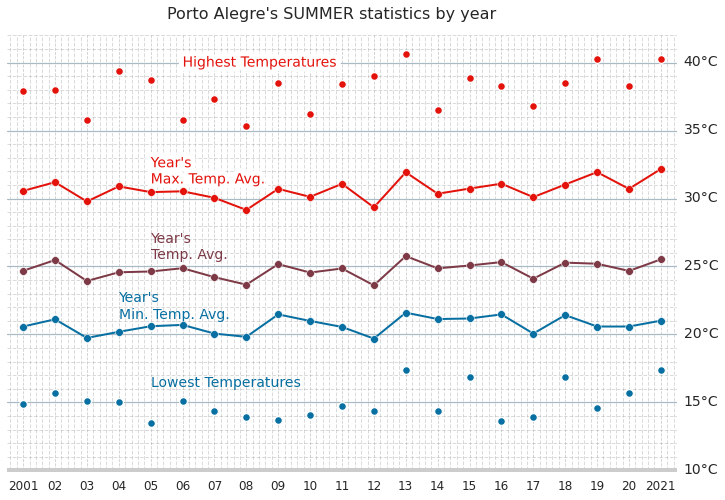

In [69]:
# These are the colors I use along this plot
COLORS = [BLUE, BROWN_DARKER, RED]
# These are the year indexes of seasons dataframe
list_years = seasons.index.year

# I use this list and for to make a list of the years
# like 01, 02, 03,..., 20, 21
two_digit_years = []
for year in list_years:
    two_digit_years.append(str(year)[2:])
two_digit_years[0] = '2001' # With this it will be easier
                            # for the user to understand
two_digit_years[20] = '2021'# the x axis

# Initialize plot -----------
fig, ax = plt.subplots(figsize=(12,8))
fig.patch.set_facecolor('white')


# Add lines with dots
for temperature, color in zip(sum_plot,COLORS):
    ax.plot(list_years, seasons[temperature], color=color,lw=2)
    ax.scatter(list_years, seasons[temperature], fc=color, s=60, lw=0.5,ec='white',zorder=12)
ax.scatter(list_years, seasons['SUM_max'], fc=RED,s=60,lw=1.2,ec='white',zorder=12)
ax.scatter(list_years, seasons['SUM_min'], fc=BLUE,s=60,lw=1.2,ec='white',zorder=12)
    
# Customize axis -----------
# Customize y-axis ticks
ax.yaxis.set_ticks([i * 5 for i in range(2,9)])
ax.yaxis.set_ticklabels([i * 5 for i in range(2,9)])
ax.yaxis.set_tick_params(labelleft=False, length=0)

# Customize x-axis ticks
ax.xaxis.set_ticks(list_years)
ax.xaxis.set_ticklabels(two_digit_years,
                        fontsize=12, #fontfamily="Econ Sans Cnd", 
                        fontweight=50)
ax.xaxis.set_tick_params(length=6, width=1.2)

# Make gridlines be below most axis
ax.set_axisbelow(True)

# Add grid lines 
ax.grid(axis = 'y', color='#A8BAC4', lw=1.2)
ax.grid(axis = 'x' ,linestyle='--', lw=0.8)
ax.minorticks_on()
ax.grid(which='minor', color='#999999', linestyle='--', alpha=0.35)

# Remove all spines but the one in the bottom
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize bottom spine
ax.spines['bottom'].set_lw(4)
ax.spines['bottom'].set_capstyle('butt')

# Set custom limits
ax.set_ylim(10,42)
ax.set_xlim(2000.5,2021.5)

# Add labels for verticcal grid lines ---------
# The pad is equal to 1% of the vertical range (17 - 35)
PAD = 18 * 0.01
for label in [i * 5 for i in range(2,9)]:
    ax.text(2022.8, label - 0.2, str(label) + '°C',
           ha='right',va='baseline', fontsize=14,
           fontweight=100)
    
# Annotate labels for variable names ---------

# Note the path effecct must be a list
path_effects = [withStroke(linewidth=10, foreground='white')]

# We create a function to avoid repeating 'ax.text' many times
def add_var_label(x, y, text, color, path_effects, ax):
    '''This function create a label with defined position and 
    arguments so we dont need to repeat ax.text many times'''
    ax.text(x,y,
           text, color=color,
           fontsize=14,
           va='center', ha='left',
           path_effects=path_effects)
var_labels = [
    {
        'x':2006,'y':40,'text':"Highest Temperatures",
        'color': RED, 'path_effects': path_effects},
    {
        'x':2005,'y':32,'text':"Year's\nMax. Temp. Avg.",
        'color': RED, 'path_effects': path_effects},
    {
        'x':2005,'y':26.5,'text':"Year's\nTemp. Avg.",
        'color': BROWN_DARKER, 'path_effects': []},
    {
        'x':2004,'y':22.1,'text':"Year's\nMin. Temp. Avg.",
        'color': BLUE, 'path_effects': []},
    {
        'x':2005,'y':16.5,'text':"Lowest Temperatures",
        'color': BLUE, 'path_effects': []}
]

for label in var_labels:
    add_var_label(**label,ax=ax)
    
plt.suptitle("Porto Alegre's SUMMER statistics by year",y=0.93,fontsize=16)

### Questions we wanted to answer about the summer:

* Did the avg temp increased in these last 7 years?

Looking to the graph it seems like it really rose up a bit. But let's further investigate it.

* Did the max temp increased too?

Yes it really look like there's a difference from the max temperatures from  the last 5 years. Let's further investigate too.

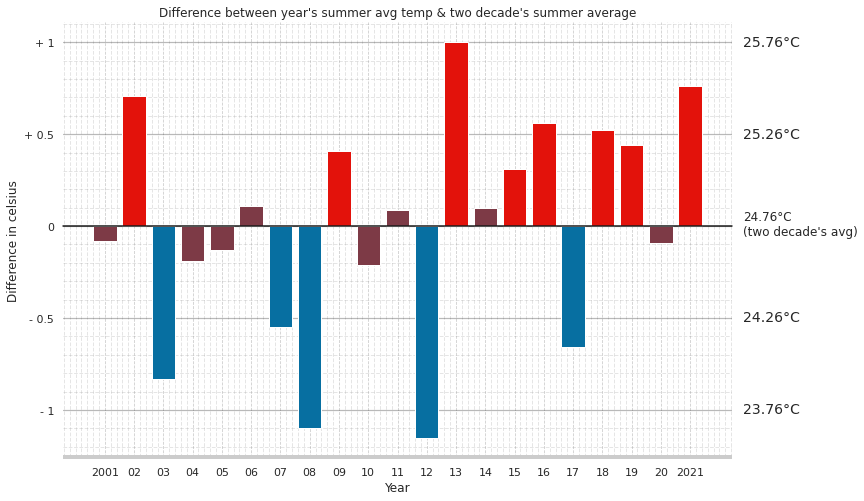

In [79]:
# We are going to setup a plot that will show the difference of each year's
# average temperature in relation to the average temperature of all two decades

def nums_to_colors(num_list: list):
    '''
    Convert a list of numbers to a list of colors scaled between red(warm) and blue(cold)
    
    Parameters:
    -----------
    num_list : A list of numbers that should be between -1.2 and 1.2. 
    
    Returns:
    -----------
    color_list: A list where each num was converted to a related color.
    
    '''
    color_list = []
    for num in num_list:
        if num < -0.8:
            color_list.append(BLUE)
        elif num < -0.3:
            color_list.append(BLUE)
        elif num < 0:
            color_list.append(BROWN_DARKER)
        elif num < 0.3:
            color_list.append(BROWN_DARKER)
        elif num < 0.8:
            color_list.append(RED)
        else:
            color_list.append(RED)
    return color_list


# Set up seaborn theme
sns.set_theme(style="whitegrid", context="notebook")

# The mean of all SUM_temp of these 20 years (24.76 celsius)
avg_summ = round(seasons['SUM_temp'].mean(), 2)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Set axes values
x = two_digit_years
# x[0],x[-1] = '01','21'
y = seasons['SUM_temp'] - avg_summ

ax.bar(x,y,color = nums_to_colors(y))
ax.axhline(0, color="k", clip_on=False)

ax.set_xlabel("Year")
ax.set_ylabel("Difference in celsius")
ax.set_title("Difference between year's summer avg temp & two decade's summer average")
ax.yaxis.set_ticks([-1,-0.5,0,0.5,1])
ax.yaxis.set_ticklabels(['- 1','- 0.5','0','+ 0.5','+ 1'])
ax.yaxis.set_tick_params(labelleft=True, length=5)

# Customize bottom spine
ax.spines['bottom'].set_lw(4)
ax.spines['bottom'].set_capstyle('butt')

# Remove all spines but the one in the bottom
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

for label in [-1,-0.5,0,0.5,1]:
    if label == 0:
            ax.text(21.8, label - 0.05, str(label + avg_summ) + "°C\n(two decade's avg)" ,
           ha='left',va='baseline', fontsize=12,
           fontweight=40)
    else:
        ax.text(21.8, label - 0.02, str(label + avg_summ) + '°C',
           ha='left',va='baseline', fontsize=14,
           fontweight=40)

ax.grid(axis = 'y', color='k', alpha=0.3,lw=1.2)
ax.grid(axis = 'x' ,linestyle='--', lw=0.8)
ax.minorticks_on()
ax.grid(which='minor', color='#999999', linestyle='--', alpha=0.25)

# seasons[['SUM_temp']] - seasons['SUM_temp'].mean()

From the graph above it really seems like the average temperatures and max temperatures really got a little higher. There are many interesting insights that can be made from this plot, but the general idea it gives to me is that all the variables are getting higher on average.

As an attempt to visualize more this change of the averages I've tried to plot a new graph with a line in the center representing the mean of all the year averages from these two decades (which is 24.76C°). After this line, I plotted on this same graph bars that represents how far each year's average is from that mean, they represent the diversion of the the values in relation to that mean/line.

In [71]:
# from matplotlib.cm import ScalarMappable

# diff_from_avg = seasons['SUM_temp'] - avg_summ

# diff_from_avg_norm = [x / max(diff_from_avg + 1.16) for x in diff_from_avg]

# my_cmap = plt.cm.get_cmap('coolwarm')
# colors = my_cmap(diff_from_avg_norm)

# sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(diff_from_avg_norm)))

# sm.to_rgba()

# cbar = plt.colorbar(sm)
# cbar.set_label('Color', rotation=270,labelpad=25)


# diff_from_avg
# diff_from_avg_norm

# (seasons['SUM_temp'] - avg_summ).iloc[:2]

In [72]:
## Did the avg temp rose up in these last 7 years?
## and did avg max temp rose up too?

# To answer this with number I create a resample with a frequency of 7y to compare
# summer variables along the years

summer_7y = seasons.resample("7A").agg([
    'mean'
]).round(2).iloc[:,0:5]
summer_7y.index = ['2001 - 2007',
                   '2008 - 2014',
                   '2015 - 2021']
summer_7y.columns = summer_7y.columns.droplevel(1)
summer_7y

,SUM_temp,SUM_max,SUM_max_avg,SUM_min,SUM_min_avg
2001 - 2007,24.62,37.56,30.50,14.81,20.43
2008 - 2014,24.64,37.79,30.39,14.66,20.75
2015 - 2021,25.02,38.77,31.11,15.57,20.90


As we can see in the plot above, the year's summer temperature average is increasing. The first decade of the century had on average lower temperatures during the summer and the second decade the opposite.

This analysis reinforce the idea that Porto Alegre's summers are getting slightly hotter. My perception that our summers are being hotter seems to be in line with data.

With the plots that I showed before and with this table that shows the mean of many variables of the city summers I feel confident to say that my perceptions are at least coherent with the data: Porto Alegre is having higher temperatures and higher averages during these last 7 years, but it's just a small difference.

We can't confirm with certainty that my perception is related to any real changes in the city's climate, but it certainly goes in the same direction that some studies already found (I will link an interesting one below), the climate change is starting to be noticeable by people who live in the city.

[Climate change in Rio Grande do Sul, by Bibiana Dávila at UFRGS](https://www.ufrgs.br/sextante/mudanca-climatica-no-rio-grande-do-sul/)

## What about the winter?

* Did the mean temperature increased?
* Did the minimum temperature average increased?

Text(0.5, 0.93, "Porto Alegre's WINTER statistics by year")

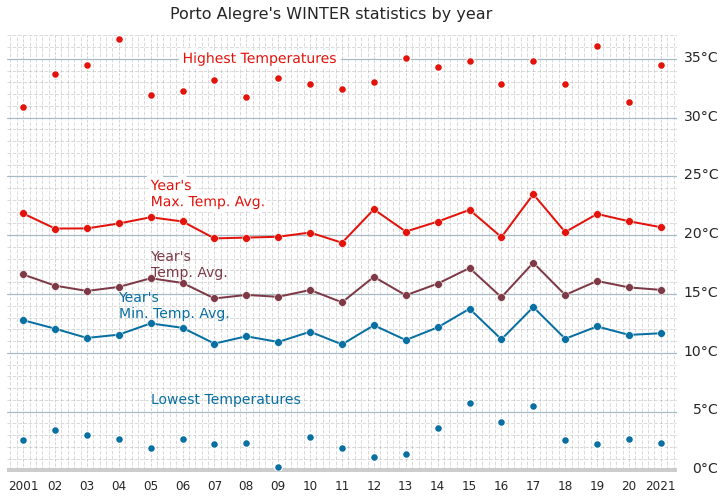

In [73]:
# These are the colors I use along this plot
COLORS = [BLUE, BROWN_DARKER, RED]
# These are the year indexes of seasons dataframe
list_years = seasons.index.year

# I use the list and for below to make a list of the years
# like 01, 02, 03,..., 20, 21
two_digit_years = []
for year in list_years:
    two_digit_years.append(str(year)[2:])
two_digit_years[0] = '2001' # With this it will be easier
                            # for the user to understand
two_digit_years[20] = '2021'# the x axis

# Initialize plot -----------
fig, ax = plt.subplots(figsize=(12,8))
fig.patch.set_facecolor('white')

# Add lines with dots
for temperature, color in zip(win_plot,COLORS):
    ax.plot(list(list_years), seasons[temperature], color=color,lw=2)
    ax.scatter(list(list_years), seasons[temperature], fc=color, s=60, lw=0.5,ec='white',zorder=12)
ax.scatter(list(list_years), seasons['WIN_max'], fc=RED,s=60,lw=1.2,ec='white',zorder=12)
ax.scatter(list(list_years), seasons['WIN_min'], fc=BLUE,s=60,lw=1.2,ec='white',zorder=12)
    
# Customize axis -----------
# Customize y-axis ticks
ax.yaxis.set_ticks([i * 5 for i in range(0,9)])
ax.yaxis.set_ticklabels([i * 5 for i in range(0,9)])
ax.yaxis.set_tick_params(labelleft=False, length=0)

# Customize x-axis ticks
ax.xaxis.set_ticks(list_years)
ax.xaxis.set_ticklabels(two_digit_years,
                        fontsize=12, #fontfamily="Econ Sans Cnd", 
                        fontweight=50)
ax.xaxis.set_tick_params(length=6, width=1.2)

# Make gridlines be below most axis
ax.set_axisbelow(True)

# Add grid lines 
ax.grid(axis = 'y', color='#A8BAC4', lw=1.2)
ax.grid(axis = 'x' ,linestyle='--', lw=0.8)
ax.minorticks_on()
ax.grid(which='minor', color='#999999', linestyle='--', alpha=0.35)

# Remove all spines but the one in the bottom
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Customize bottom spine
ax.spines['bottom'].set_lw(4)
ax.spines['bottom'].set_capstyle('butt')

# Set custom limits
ax.set_ylim(0,37)
ax.set_xlim(2000.5,2021.5)

# Add labels for verticcal grid lines ---------
# The pad is equal to 1% of the vertical range (17 - 35)
PAD = 18 * 0.01
for label in [i * 5 for i in range(0,8)]:
    ax.text(2022.8, label - 0.2, str(label) + '°C',
           ha='right',va='baseline', fontsize=14,
           fontweight=100)
    
# Annotate labels for variable names ---------

# Note the path effecct must be a list
path_effects = [withStroke(linewidth=10, foreground='white')]

# We create a function to avoid repeating 'ax.text' many times
def add_var_label(x, y, text, color, path_effects, ax):
    '''This function create a label with defined position and 
    arguments so we dont need to repeat ax.text many times'''
    ax.text(x,y,
           text, color=color,
           fontsize=14,
           va='center', ha='left',
           path_effects=path_effects)
var_labels = [
    {
        'x':2006,'y':35,'text':"Highest Temperatures",
        'color': RED, 'path_effects': path_effects},
    {
        'x':2005,'y':23.5,'text':"Year's\nMax. Temp. Avg.",
        'color': RED, 'path_effects': path_effects},
    {
        'x':2005,'y':17.5,'text':"Year's\nTemp. Avg.",
        'color': BROWN_DARKER, 'path_effects': []},
    {
        'x':2004,'y':14,'text':"Year's\nMin. Temp. Avg.",
        'color': BLUE, 'path_effects': []},
    {
        'x':2005,'y':6,'text':"Lowest Temperatures",
        'color': BLUE, 'path_effects': []}
]

for label in var_labels:
    add_var_label(**label,ax=ax)
    
plt.suptitle("Porto Alegre's WINTER statistics by year",y=0.93,fontsize=16)

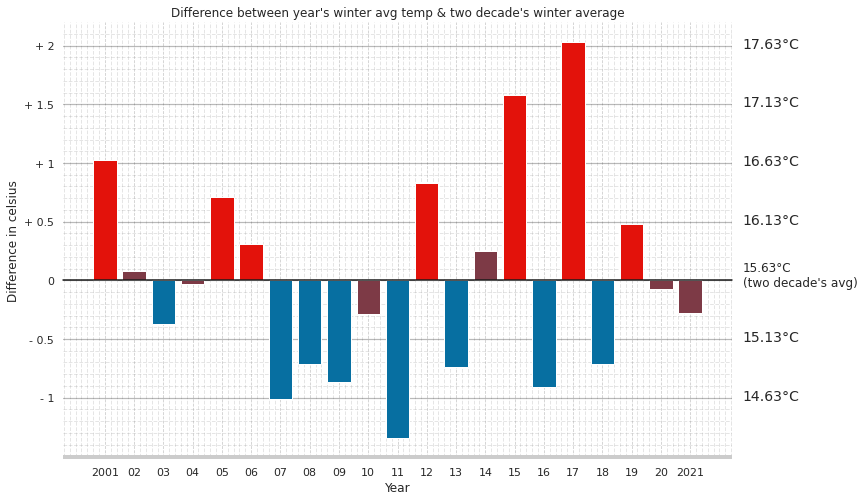

In [74]:
# We are going to setup a plot that will show the difference of each year's
# average temperature in relation to the average temperature of all two decades

def nums_to_colors(num_list: list):
    '''
    Convert a list of numbers to a list of colors scaled between red(warm) and blue(cold)
    
    Parameters:
    -----------
    num_list : A list of numbers that should be between -1.2 and 1.2. 
    
    Returns:
    -----------
    color_list: A list where each num was converted to a related color.
    
    '''
    color_list = []
    for num in num_list:
        if num < -0.8:
            color_list.append(BLUE)
        elif num < -0.3:
            color_list.append(BLUE)
        elif num < 0:
            color_list.append(BROWN_DARKER)
        elif num < 0.3:
            color_list.append(BROWN_DARKER)
        elif num < 0.8:
            color_list.append(RED)
        else:
            color_list.append(RED)
    return color_list


# Set up seaborn theme
sns.set_theme(style="whitegrid", context="notebook")

# The mean of all SUM_temp of these 20 years (24.76 celsius)
avg_summ = round(seasons['WIN_temp'].mean(), 2)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Set axes values
x = two_digit_years
# x[0],x[-1] = '01','21'
y = seasons['WIN_temp'] - avg_summ

ax.bar(x,y,color = nums_to_colors(y))
ax.axhline(0, color="k", clip_on=False)

ax.set_xlabel("Year")
ax.set_ylabel("Difference in celsius")
ax.set_title("Difference between year's winter avg temp & two decade's winter average")
ax.yaxis.set_ticks([-1,-0.5,0,0.5,1, 1.5, 2])
ax.yaxis.set_ticklabels(['- 1','- 0.5','0','+ 0.5','+ 1', '+ 1.5', '+ 2'])
ax.yaxis.set_tick_params(labelleft=True, length=5)

# Customize bottom spine
ax.spines['bottom'].set_lw(4)
ax.spines['bottom'].set_capstyle('butt')

# Remove all spines but the one in the bottom
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

for label in [-1,-0.5,0,0.5,1,1.5,2]:
    if label == 0:
            ax.text(21.8, label - 0.05, str(label + avg_summ) + "°C\n(two decade's avg)" ,
           ha='left',va='baseline', fontsize=12,
           fontweight=40)
    else:
        ax.text(21.8, label - 0.02, str(round((label + avg_summ), 2)) + '°C',
           ha='left',va='baseline', fontsize=14,
           fontweight=40)

ax.grid(axis = 'y', color='k', alpha=0.3,lw=1.2)
ax.grid(axis = 'x' ,linestyle='--', lw=0.8)
ax.minorticks_on()
ax.grid(which='minor', color='#999999', linestyle='--', alpha=0.25)

# seasons[['SUM_temp']] - seasons['SUM_temp'].mean()

In [75]:
winter_7y = seasons.resample('7A')
winter_7y = winter_7y.agg([
    'mean'
]).round(2).iloc[:,7:-2]
winter_7y.index = ['2001 - 2007',
                    '2008 - 2014',
                    '2015 - 2021']
winter_7y.columns = winter_7y.columns.droplevel(1)
winter_7y

,WIN_temp,WIN_max,WIN_max_avg,WIN_min,WIN_min_avg
2001 - 2007,15.73,33.31,20.92,2.64,11.86
2008 - 2014,15.22,33.27,20.42,1.91,11.49
2015 - 2021,15.93,33.90,21.35,3.59,12.20


With the winter we can see a similar pattern to the one that our summer is following: average temperatues, maximum and minimum variables are all (somewhat) increasing. All the variables had some increase, but the maximum averages and the two minimum variables (average and lowest temperature) had highest increase.

The average temperatures seems to be getting higher and all the other metrics too. Answering our questions: Yes, the mean temperature average suffered an increase and the miniminum temperatures (and averages) suffered too.

Again, we, citizens, can feel a difference and this difference can be felt by our sensations.

## Humidity

Questions we want to answer:

* Did the humidity averages suffered any changes along these years?
* Does it follows the changes of other variables?



In [76]:
poaw_7y = poaw.loc[:'2021-12-31'].resample('7AS').agg([
    'mean'
])

poaw_7y_hum = poaw_7y.round(2).loc[:,['avg_humidity','min_humidity']]
poaw_7y_hum.index = ['2001 - 2007',
                       '2008 - 2014',
                       '2015 - 2021']
poaw_7y_hum.columns = poaw_7y_hum.columns.droplevel(1)
poaw_7y_hum

,avg_humidity,min_humidity
2001 - 2007,74.09,51.16
2008 - 2014,75.47,52.34
2015 - 2021,77.85,54.83


The average humidity and minimum humidity mantained themselves in a similar averages along these 20 years although they seem to be increasing too. I'm no specialist, so I can't affirm anything, even if there's a small increase on it. It can be only a common difference or something else, only a little bit of more research from my part can understand it further.

Answering the questions: they seems to be increasing although it's a subtle difference. As all the other variables seems to be increasing too I can say that this change is following the changes of other metrics

## Precipitation

Questions we want to answer:

* Did the monthly precipitations sums had suffered some kind of change trough the years?

In [77]:
poaw_7y = poaw.loc[:'2021-12-31'].resample('7AS').agg([
    'sum'
])
poaw_7y.index = ['2001 - 2007',
                       '2008 - 2014',
                       '2015 - 2021']
poaw_7y_prec = poaw_7y.iloc[:,0]
poaw_7y_prec.name = ('Sum of precipitation (mm)')
poaw_7y_prec.to_frame()


,Sum of precipitation (mm)
2001 - 2007,7532.4
2008 - 2014,10567.8
2015 - 2021,10809.8


In [78]:
poaw_10y = poaw.loc[:'2021-12-31'].resample('10AS').agg([
    'sum'
])
poaw_10y.index = ['2001 - 2010',
                       '2011 - 2020',
                       '2021 - 2021']
poaw_10y_prec = poaw_10y.iloc[:,0]
poaw_10y_prec.name = ('Sum of precipitation (mm)')
poaw_10y_prec.to_frame()

,Sum of precipitation (mm)
2001 - 2010,12258.6
2011 - 2020,15431.4
2021 - 2021,1220.0


In this last table we are able to see that we having considerable more rain in this last decade of 2011 to 2020. Being specific: the difference between 2001-2010 sum and the 2011-2020 sum is 3172.8mm more precipitation for the latter.

This tendency towards a higher amount of precipitation is something expected in the climate change context of the state we are in. Rio Grande do Sul suffers from the climate changes that are being made trough the amazon forest deforestation, in more than one way it intensifies the precipitations on our region.

# What's next?

After this EDA I'm planning to explore other parts of this data (like thermal amplitude) and if I can get more data (other years) I will thing about doing some forecasting.

This will only happen in the future, so see you next time!